# **Predicting Raw Material < 100 points**

## **Notebook Functionality**:




* Resample and use `skforecast` library to predict the raw materials with less than 100 points.
* Even though when reading the length of the data frames, it shows it has more points, it is because it has 0's in many rows. This is because their demand is intermittent, and spaced out. 

# 1.0. Setup

In [ ]:
! pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 4.8 MB/s 
     |████████████████████████████████| 76 kB 4.2 MB/s 
     |████████████████████████████████| 9.8 MB 28.2 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Importing required modules
import os
import math
import glob
import sklearn
import itertools
from xgboost import XGBRegressor
import statistics
import numpy as np 
import pandas as pd
import datetime as dt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from sklearn.metrics import make_scorer
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import shapiro
from scipy.stats import kurtosis, skew
from IPython.core.interactiveshell import no_op
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

sns.set()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2.0. Defining Functions

## 2.1. Data Processing Functions

In [ ]:
def train_test_split(data, n_test):
	""" This function splits the dataset into train and test """
	return data[:-n_test], data[-n_test:]

In [ ]:
def find_outliers_IQR(df):
  """ This function finds outliers and also returns the maximum value of the outlier upper bound """
  q1=df.quantile(0.25)
  q3=df.quantile(0.75)
  IQR=q3-q1
  outliers = df[(df>(q3+2*IQR))]
  max_val = float(q3+2*IQR)

  return outliers, max_val

## 2.2. XGBoost Functions

In [ ]:
def season(mydate):
  """ This function creates seasons for the year, which will then be used as part of the creation of new features """
  
  # get the year from the date object
  year = mydate.year

  # create a list of seasons for comparison
  seasons = [
      (2, dt.date(year, 12, 21), dt.date(year, 12, 31)),
      (4, dt.date(year, 6, 21), dt.date(year, 9, 20)),
      (1, dt.date(year, 9, 21), dt.date(year, 12, 20)),
      (2, dt.date(year, 1, 1), dt.date(year, 3, 20)),
      (3, dt.date(year, 3, 21), dt.date(year, 6, 20)),
    ]

  # find the corresponding from the list and return it
  for season in seasons:
      if mydate >= season[1] and mydate <= season[2]:
          return season[0]

In [ ]:
def clean_dataframe(df):
  """ This is a function to clean the dataframe that is not resampled """
  
  df = df.drop(columns = ['unidad','denominacion','denominacion_fleje','bobina_de_fabricacion','denominacion_bobina'])
  df.rename(columns = {'fecha':'ds','cantidad_de_acero_necesario_tm':'y'},inplace = True)
  df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
  df = df.set_index('ds')
  df = df.sort_index()
  df.reset_index(inplace = True)
  df = df[['ds','y']]
  df['ds'] = pd.to_datetime(df['ds'])

  return df

In [ ]:
 def resample_df(df, resampling_param= 'W'): 
   """ This function is to resample the cleaned data frame """

   df = df.set_index('ds')
   df =  df.resample(resampling_param).sum()
   df = df.asfreq(resampling_param)
   df = df.sort_index()

   return df

In [ ]:
def performance_forecast(forecast, df_test):
  """This function is to evaluate the performance metrics of the forecast"""

  metrics = {
      'MAE': [round(mean_absolute_error(df_test,forecast),2)],
      'MSE': [round(mean_squared_error(df_test, forecast),2)],
      'MAPE': [round(mean_absolute_percentage_error(df_test,forecast),2)],
      'WAPE': [round(abs((df_test - forecast).sum()) / (df_test).sum(),2)]
  }

  performance_metrics = pd.DataFrame(data=metrics)
  
  return performance_metrics

In [ ]:
def get_holiday(date):
  """ This function is to create a to create a column indicating whether it was a holiday in spain or not"""

  spain_holidays = ['2015-12-31', '2016-12-31','2017-12-31', '2018-12-31', '2019-12-31',
                   '2020-12-31', '2021-12-31', '2022-12-31','2016-01-06', '2017-01-06',
                   '2018-01-06', '2019-01-06','2020-01-06', '2021-01-06', '2022-01-06', 
                   '2023-01-06','2020-04-09', '2021-04-01', '2022-04-14','2020-04-10', 
                   '2021-04-02', '2022-04-15','2015-05-01', '2016-05-01','2017-05-01',
                   '2018-05-01','2019-05-01','2020-05-01', '2021-05-01', '2022-05-01',
                   '2015-08-15','2017-08-15', '2018-08-15','2019-08-15','2020-08-15',
                   '2021-08-15', '2022-08-15','2015-10-12', '2016-10-12','2017-10-12',
                   '2018-10-12','2019-10-12','2020-10-12', '2021-10-12', '2022-10-12',
                   '2015-11-02', '2016-11-02','2017-11-02', '2018-11-02','2019-11-02',
                   '2020-11-02', '2021-11-02', '2022-11-02','2015-12-06', '2016-12-06',
                   '2017-12-06', '2018-12-06','2019-12-06''2020-12-06', '2021-12-06', 
                   '2022-12-06','2015-12-08', '2016-12-08','2017-12-08', '2018-12-08',
                    '2019-12-08,','2020-12-08', '2021-12-08', '2022-12-08','2015-12-24', 
                   '2016-12-24', '2017-12-24','2018-12-24', '2019-12-24', '2020-12-24', '2021-12-24', '2022-12-24']
  
  return np.where(date.isin(spain_holidays),1,0)

In [ ]:
def create_features(df, label=None):
    """This function creates new exogeneous features for the model"""

    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.weekofyear
    df['season'] = df['ds'].map(season)
    df['highseason'] = np.where(df['ds'].map(season) == 3, 1, 0) 
    df['holiday'] = get_holiday(df['ds'])
    df['y_log1p'] = np.log1p(df['y'].fillna(method='ffill'))
    

    return df

In [ ]:
def my_scorer(y_true, y_pred):
  """ This function creates a scorer to calculate WAPE for the gridsearch when evaluating the performance of XGBoost """
  error = abs((y_true - y_pred)).sum() / (y_true).sum()
  return error

In [ ]:
my_func = make_scorer(my_scorer)

In [ ]:
def split_feat_predictors(df,label = 'y'):
  """ This function is to split the predictors vs. the predicted """

  X = df.loc[:, ~df.columns.isin(['y', 'y_log1p'])]

  y = df[label]
  return X, y

In [ ]:
def timeseries_xgboost_skforecast(df,n_test):
  """This function is to get the predicted values with skforecast """
  
  (df.index == pd.date_range(
                    start = df.index.min(),
                    end   = df.index.max(),
                    freq  = df.index.freq)).all()

  print(f'Number of Missing Values: {df.isnull().any(axis=1).mean()}')

  data_train, data_test = train_test_split(df,n_test)

  #Treat outliers in the train set
  outliers, max_val = find_outliers_IQR(data_train['y'])
  data_train['anomaly'] = data_train["y"].isin(outliers)
  data_train.loc[data_train['anomaly'] == True,'y'] = np.nan
  data_train['y'] = data_train['y'].fillna(value=max_val)
  data_train.drop(columns='anomaly',inplace=True)

  X_train, y_train = split_feat_predictors(data_train,label = 'y')
  X_test, y_test = split_feat_predictors(data_test, label = 'y')  


  forecaster = ForecasterAutoreg(
              regressor = XGBRegressor(random_state=123),
              lags = 7
              )
  


    #Grid Search
  param_grid = {
  'n_estimators': [100, 500,1000,1500,2000],
  'max_depth': [3, 5, 10],
  'learning_rate': [0.01, 0.05,0.1],
  'colsample_bytree':[0.3,0.7]}



  steps = n_test
  lags_grid = [1, 2, 3,4,5,6]

  results_grid = grid_search_forecaster(
      forecaster         = forecaster,
      y                  =  y_train,
      exog               =  X_train,
      param_grid         = param_grid,
      lags_grid          = lags_grid,
      steps              = steps,
      refit              = False,
      metric             = my_scorer,
      initial_train_size = int(len(data_train)*0.5), # Model is trained with trainign data
      fixed_train_size   = False,
      return_best = True)
  

  

  return forecaster

In [ ]:
def performance_forecast_skforecast(df,steps,forecaster):
    #Treat outliers in the train set
  outliers, max_val = find_outliers_IQR(data_train['y'])
  data_train['anomaly'] = data_train["y"].isin(outliers)
  data_train.loc[data_train['anomaly'] == True,'y'] = np.nan
  data_train['y'] = data_train['y'].fillna(value=max_val)
  data_train.drop(columns='anomaly',inplace=True)

  X_train, y_train = split_feat_predictors(data_train,label = 'y')
  X_test, y_test = split_feat_predictors(data_test, label = 'y')  

  
  return forecaster.predict(steps=steps, exog= X_train)




# 3.0. Running the Model 



In [ ]:

  
# csv files in the path
path = "/content/drive/MyDrive/Capstone/Notebooks and Data/Final_datasets/Bobinas csv no resample/No Resample Bobinas >100/1004230.csv"

data = pd.read_csv(path, index_col=None)
data = clean_dataframe(data)
data = create_features(data)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
data.head()

,ds,y,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,highseason,holiday,y_log1p
0,2016-01-06,7.52,1,1,2016,6,6,1,2,0,0,2.142416
1,2016-01-08,0.80,1,1,2016,8,8,1,2,0,0,0.587787
2,2016-01-29,0.20,1,1,2016,29,29,4,2,0,0,0.182322
3,2016-02-19,0.14,1,2,2016,50,19,7,2,0,0,0.131028
4,2016-02-25,0.20,1,2,2016,56,25,8,2,0,0,0.182322


In [ ]:
resample_param = 'SM'
data = resample_df(data,resample_param)

if resample_param == 'W':
  n_test = 20
  resampled = 'weekly'
elif resample_param == 'M':
  n_test = 5
  resampled = 'monthly'
elif resample_param  == 'SM':
  n_test = 10
  resampled = 'two weeks'
elif resample_param == 'BM':
  n_test = 20
  resampled = 'business monthly'
elif resample_param == 'D':
  n_test = 150
  resampled = 'daily'

else:
  pass


Data frame has been resampled: two weeks and nos has 141rows and 11 columns
Count of zeros in column y is: 74
Count of zeros in column quarter is: 74
Count of zeros in column month is: 74
Count of zeros in column year is: 74
Count of zeros in column dayofyear is: 74
Count of zeros in column dayofmonth is: 74
Count of zeros in column weekofyear is: 74
Count of zeros in column season is: 74
Count of zeros in column highseason is: 123
Count of zeros in column holiday is: 141
Count of zeros in column y_log1p is: 74


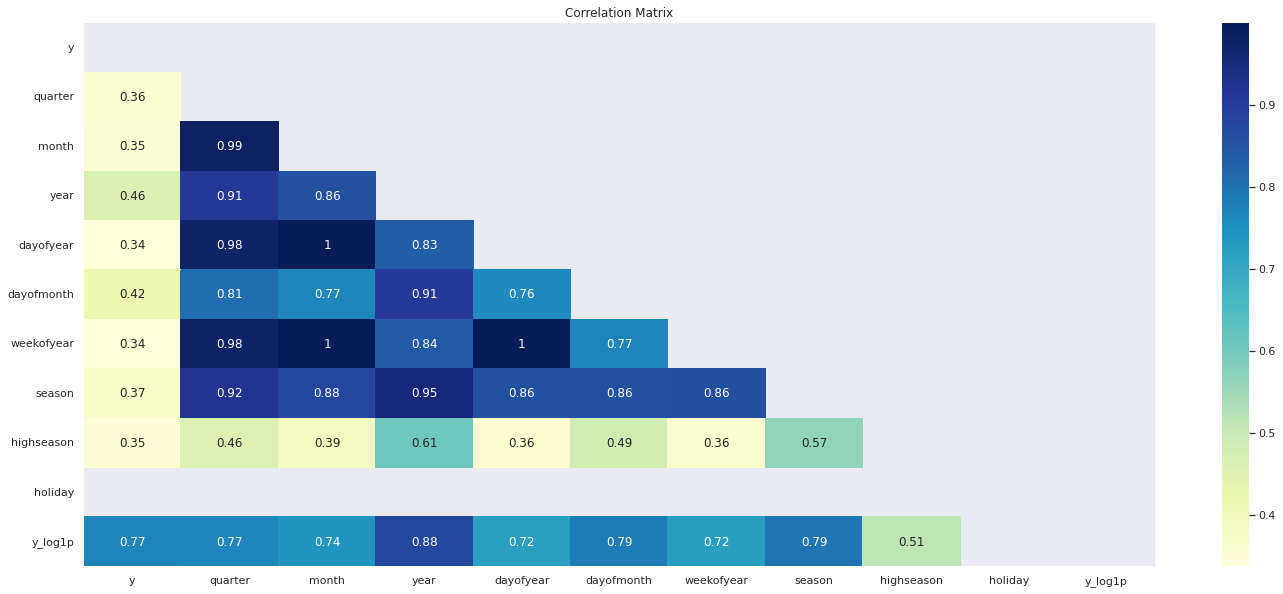

In [ ]:
print(f'Data frame has been resampled: {resampled} and nos has {data.shape[0]}rows and {data.shape[1]} columns')








# Count number of zeros in all columns 
for column_name in data.columns:
  column = data[column_name]
  count = (column == 0).sum()
  print('Count of zeros in column', column_name, 'is:', count)

plt.figure(figsize = (24,10))
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot = True, cmap="YlGnBu", mask=matrix)
plt.title("Correlation Matrix")
plt.show()


In [ ]:
data_train, data_test = train_test_split(data,n_test)

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})") 


Dates train      : 2015-12-31 00:00:00 --- 2021-05-31 00:00:00  (n=131)
Dates test       : 2021-06-15 00:00:00 --- 2021-10-31 00:00:00  (n=10)


In [ ]:
(data.index == pd.date_range(
                    start = data.index.min(),
                    end   = data.index.max(),
                    freq  = data.index.freq)).all()

print(f'Number of Missing Values: {data.isnull().any(axis=1).mean()}')



#Treat outliers in the train set
outliers, max_val = find_outliers_IQR(data_train['y'])
data_train['anomaly'] = data_train["y"].isin(outliers)
data_train.loc[data_train['anomaly'] == True,'y'] = np.nan
data_train['y'] = data_train['y'].fillna(value=max_val)
data_train.drop(columns='anomaly',inplace=True)

X_train, y_train = split_feat_predictors(data_train,label = 'y')
X_test, y_test = split_feat_predictors(data_test, label = 'y')  


forecaster = ForecasterAutoreg(
              regressor = XGBRegressor(random_state=123),
              lags = 7
              )
  



Number of Missing Values: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [ ]:

#Grid Search
param_grid = {
'n_estimators': [100, 500,1000,1500,2000],
'max_depth': [3, 5, 10],
'learning_rate': [0.01, 0.05,0.1],
'colsample_bytree':[0.3,0.7]}



steps = n_test
lags_grid = [1, 2, 3,4,5,6,8,10,24]

results_grid = grid_search_forecaster(
      forecaster         = forecaster,
      y                  =  y_train,
      exog               =  X_train,
      param_grid         = param_grid,
      lags_grid          = lags_grid,
      steps              = steps,
      refit              = False,
      metric             = my_scorer,
      initial_train_size = int(len(data_train)*0.5), # Model is trained with trainign data
      fixed_train_size   = False,
      return_best = True)
  

  



Number of models compared: 810


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:06, 13.40it/s]

[00:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:10,  8.11it/s]

[00:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:09,  8.36it/s]

[00:37:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:10,  7.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:12,  6.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  11%|████                                | 10/90 [00:01<00:14,  5.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  14%|█████▏                              | 13/90 [00:01<00:11,  6.59it/s]

[00:37:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:13,  5.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  19%|██████▊                             | 17/90 [00:02<00:11,  6.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  20%|███████▏                            | 18/90 [00:02<00:11,  6.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  21%|███████▌                            | 19/90 [00:02<00:11,  6.24it/s]

[00:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  24%|████████▊                           | 22/90 [00:03<00:09,  7.47it/s]

[00:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:09,  7.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  27%|█████████▌                          | 24/90 [00:03<00:09,  6.74it/s]

[00:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  30%|██████████▊                         | 27/90 [00:04<00:08,  7.56it/s]

[00:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:08,  7.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:09,  6.73it/s]

[00:37:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  36%|████████████▊                       | 32/90 [00:04<00:07,  7.87it/s]

[00:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  37%|█████████████▏                      | 33/90 [00:04<00:07,  7.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  39%|██████████████                      | 35/90 [00:05<00:08,  6.43it/s]

[00:37:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  41%|██████████████▊                     | 37/90 [00:05<00:06,  8.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  42%|███████████████▏                    | 38/90 [00:05<00:06,  8.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  44%|████████████████                    | 40/90 [00:05<00:07,  6.65it/s]

[00:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  47%|████████████████▊                   | 42/90 [00:06<00:05,  8.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:06<00:05,  8.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  50%|██████████████████                  | 45/90 [00:06<00:06,  6.56it/s]

[00:37:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:06<00:05,  8.50it/s]

[00:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  53%|███████████████████▏                | 48/90 [00:06<00:05,  8.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:05,  6.94it/s]


    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-30 00:00:00
Data partition in fold: 5
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-10-15 00:00:00 -- 2021-02-28 00:00:00
Data partition in fold: 6
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2021-03-15 00:00:00 -- 2021-05-31 00:00:00

[00:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
   


loop param_grid:  58%|████████████████████▊               | 52/90 [00:07<00:05,  7.36it/s]

[00:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:07<00:05,  6.84it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  60%|█████████████████████▌              | 54/90 [00:07<00:06,  5.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  61%|██████████████████████              | 55/90 [00:08<00:07,  4.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:08<00:05,  6.27it/s]

[00:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:08<00:05,  5.69it/s]

[00:37:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:08<00:06,  4.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  67%|████████████████████████            | 60/90 [00:09<00:08,  3.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  69%|████████████████████████▊           | 62/90 [00:09<00:06,  4.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:09<00:05,  4.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:10<00:06,  4.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  72%|██████████████████████████          | 65/90 [00:10<00:06,  3.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  74%|██████████████████████████▊         | 67/90 [00:10<00:04,  4.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:11<00:04,  4.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:11<00:04,  4.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  78%|████████████████████████████        | 70/90 [00:11<00:05,  3.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  80%|████████████████████████████▊       | 72/90 [00:11<00:03,  4.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:03,  4.89it/s]

[00:37:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:12<00:03,  4.77it/s]

[00:37:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:12<00:02,  6.16it/s]

[00:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:12<00:01,  6.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  6.01it/s]

[00:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:13<00:01,  7.48it/s]

[00:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:13<00:00,  7.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:13<00:00,  6.93it/s]


[00:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 

loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:14<00:00,  7.78it/s]

[00:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:14<00:00,  7.51it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:14<00:00,  6.93it/s]


[00:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 

loop param_grid:   2%|▊                                    | 2/90 [00:00<00:06, 14.32it/s]

[00:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:10,  8.24it/s]

[00:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:09,  8.50it/s]

[00:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:10,  7.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:12,  6.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  11%|████                                | 10/90 [00:01<00:15,  5.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  14%|█████▏                              | 13/90 [00:01<00:12,  6.36it/s]

[00:37:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:14,  5.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  19%|██████▊                             | 17/90 [00:02<00:12,  6.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  20%|███████▏                            | 18/90 [00:02<00:11,  6.28it/s]

[00:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  21%|███████▌                            | 19/90 [00:02<00:11,  5.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  24%|████████▊                           | 22/90 [00:03<00:09,  7.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:09,  6.95it/s]

[00:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  27%|█████████▌                          | 24/90 [00:03<00:10,  6.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  28%|██████████                          | 25/90 [00:03<00:11,  5.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:09,  6.79it/s]

[00:37:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:09,  6.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  36%|████████████▊                       | 32/90 [00:04<00:07,  7.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  37%|█████████████▏                      | 33/90 [00:05<00:07,  7.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.71it/s]

[00:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  41%|██████████████▊                     | 37/90 [00:05<00:06,  7.57it/s]

[00:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  42%|███████████████▏                    | 38/90 [00:05<00:07,  7.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:08,  6.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  44%|████████████████                    | 40/90 [00:06<00:08,  5.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:06<00:06,  7.01it/s]

[00:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:06<00:07,  6.53it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  50%|██████████████████                  | 45/90 [00:06<00:07,  5.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:05,  7.03it/s]

[00:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:06,  6.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  56%|████████████████████                | 50/90 [00:07<00:07,  5.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:05,  6.39it/s]

[00:37:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  60%|█████████████████████▌              | 54/90 [00:08<00:06,  5.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  61%|██████████████████████              | 55/90 [00:08<00:07,  4.51it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:08<00:05,  6.00it/s]

[00:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:09<00:05,  5.57it/s]

[00:37:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:09<00:06,  4.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  67%|████████████████████████            | 60/90 [00:09<00:07,  3.82it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-

loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:10<00:04,  5.72it/s]

[00:37:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:10<00:04,  5.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  72%|██████████████████████████          | 65/90 [00:10<00:04,  5.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:10<00:03,  6.53it/s]

[00:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:11<00:03,  6.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  78%|████████████████████████████        | 70/90 [00:11<00:03,  5.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:11<00:02,  6.74it/s]

[00:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:11<00:02,  6.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  86%|██████████████████████████████▊     | 77/90 [00:12<00:01,  7.45it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:12<00:01,  7.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:12<00:01,  6.58it/s]

[00:37:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  91%|████████████████████████████████▊   | 82/90 [00:13<00:01,  7.75it/s]

[00:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:13<00:00,  7.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  94%|██████████████████████████████████  | 85/90 [00:13<00:00,  6.30it/s]

[00:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:13<00:00,  7.99it/s]

[00:37:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:13<00:00,  7.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:14<00:00,  6.99it/s]

[00:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:06, 13.73it/s]

[00:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:10,  8.02it/s]

[00:37:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  8.18it/s]

[00:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:10,  7.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:12,  6.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  11%|████                                | 10/90 [00:01<00:15,  5.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  14%|█████▏                              | 13/90 [00:01<00:12,  6.23it/s]

[00:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:14,  5.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  17%|██████                              | 15/90 [00:02<00:17,  4.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  20%|███████▏                            | 18/90 [00:02<00:11,  6.20it/s]

[00:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:12,  5.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  22%|████████                            | 20/90 [00:03<00:13,  5.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:09,  6.75it/s]

[00:37:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  27%|█████████▌                          | 24/90 [00:03<00:10,  6.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  28%|██████████                          | 25/90 [00:04<00:12,  5.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:09,  6.42it/s]

[00:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:10,  5.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:08,  6.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  37%|█████████████▏                      | 33/90 [00:05<00:08,  6.94it/s]

[00:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  39%|██████████████                      | 35/90 [00:05<00:09,  5.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  42%|███████████████▏                    | 38/90 [00:05<00:07,  7.34it/s]

[00:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  6.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  44%|████████████████                    | 40/90 [00:06<00:08,  6.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:06<00:06,  7.39it/s]

[00:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:06<00:06,  6.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:07<00:05,  7.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:05,  7.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:06,  6.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  56%|████████████████████                | 50/90 [00:07<00:07,  5.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:05,  6.39it/s]

[00:37:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  60%|█████████████████████▌              | 54/90 [00:08<00:06,  5.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  61%|██████████████████████              | 55/90 [00:08<00:07,  4.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:05,  5.89it/s]

[00:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:09<00:05,  5.40it/s]

[00:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:09<00:06,  4.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  69%|████████████████████████▊           | 62/90 [00:10<00:05,  5.40it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:10<00:04,  5.60it/s]

[00:37:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:10<00:04,  5.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  72%|██████████████████████████          | 65/90 [00:10<00:05,  4.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:11<00:03,  6.45it/s]

[00:37:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:11<00:03,  6.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  78%|████████████████████████████        | 70/90 [00:11<00:03,  5.46it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:11<00:02,  6.84it/s]

[00:37:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:12<00:02,  6.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  83%|██████████████████████████████      | 75/90 [00:12<00:02,  5.58it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-

loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:12<00:01,  7.16it/s]

[00:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:12<00:01,  6.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  89%|████████████████████████████████    | 80/90 [00:13<00:01,  5.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:13<00:00,  7.42it/s]

[00:38:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:13<00:00,  6.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  94%|██████████████████████████████████  | 85/90 [00:13<00:00,  6.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:14<00:00,  7.54it/s]

[00:38:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:14<00:00,  6.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop lags_grid:  33%|█████████████                          | 3/9 [00:43<01:26, 14.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:   0%|                                             | 0/90 [00:00<?, ?it/s]

[00:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:07, 12.56it/s]

[00:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.62it/s]

[00:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  8.09it/s]

[00:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:11,  7.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:12,  6.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  11%|████                                | 10/90 [00:01<00:15,  5.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  14%|█████▏                              | 13/90 [00:01<00:12,  6.24it/s]

[00:38:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:14,  5.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  17%|██████                              | 15/90 [00:02<00:17,  4.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  20%|███████▏                            | 18/90 [00:02<00:11,  6.16it/s]

[00:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:12,  5.85it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  22%|████████                            | 20/90 [00:03<00:13,  5.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:10,  6.67it/s]

[00:38:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  27%|█████████▌                          | 24/90 [00:03<00:11,  5.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  28%|██████████                          | 25/90 [00:04<00:12,  5.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:09,  6.37it/s]

[00:38:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:10,  5.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  33%|████████████                        | 30/90 [00:05<00:12,  4.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  37%|█████████████▏                      | 33/90 [00:05<00:08,  6.70it/s]

[00:38:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  39%|██████████████                      | 35/90 [00:05<00:09,  5.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  42%|███████████████▏                    | 38/90 [00:06<00:07,  7.17it/s]

[00:38:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  6.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  44%|████████████████                    | 40/90 [00:06<00:08,  5.73it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:06<00:06,  6.95it/s]

[00:38:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:07,  6.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:07<00:05,  7.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:06,  6.95it/s]

[00:38:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:06,  6.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  56%|████████████████████                | 50/90 [00:08<00:07,  5.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:06,  6.07it/s]

[00:38:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  60%|█████████████████████▌              | 54/90 [00:08<00:06,  5.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  61%|██████████████████████              | 55/90 [00:09<00:08,  4.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:05,  5.60it/s]

[00:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:09<00:06,  5.14it/s]

[00:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  66%|███████████████████████▌            | 59/90 [00:09<00:07,  4.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  67%|████████████████████████            | 60/90 [00:10<00:08,  3.55it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:10<00:05,  5.35it/s]

[00:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:10<00:05,  5.06it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  72%|██████████████████████████          | 65/90 [00:11<00:05,  4.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:11<00:03,  6.19it/s]

[00:38:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:11<00:03,  5.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  78%|████████████████████████████        | 70/90 [00:11<00:03,  5.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:02,  6.50it/s]

[00:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:12<00:02,  5.84it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  83%|██████████████████████████████      | 75/90 [00:12<00:02,  5.24it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:13<00:01,  6.76it/s]

[00:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  6.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  89%|████████████████████████████████    | 80/90 [00:13<00:01,  5.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:13<00:00,  7.18it/s]

[00:38:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:14<00:00,  6.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  94%|██████████████████████████████████  | 85/90 [00:14<00:00,  5.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:14<00:00,  7.33it/s]

[00:38:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:14<00:00,  6.67it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop lags_grid:  44%|█████████████████▎                     | 4/9 [00:58<01:13, 14.71s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:   0%|                                             | 0/90 [00:00<?, ?it/s]

[00:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:07, 12.08it/s]

[00:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.28it/s]


[00:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   6%|██                                   | 5/90 [00:00<00:14,  5.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:11,  6.85it/s]

[00:38:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:13,  5.90it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  11%|████                                | 10/90 [00:01<00:16,  4.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  13%|████▊                               | 12/90 [00:01<00:12,  6.36it/s]

[00:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:13,  5.79it/s]

[00:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:15,  4.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  17%|██████                              | 15/90 [00:02<00:19,  3.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:12,  5.78it/s]

[00:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:12,  5.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  22%|████████                            | 20/90 [00:03<00:13,  5.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:09,  6.75it/s]

[00:38:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:10,  6.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  28%|██████████                          | 25/90 [00:04<00:11,  5.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:08,  6.99it/s]

[00:38:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:09,  6.41it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:07,  7.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  37%|█████████████▏                      | 33/90 [00:05<00:07,  7.26it/s]

[00:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.73it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  39%|██████████████                      | 35/90 [00:05<00:09,  5.99it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  42%|███████████████▏                    | 38/90 [00:06<00:06,  7.56it/s]

[00:38:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  7.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  44%|████████████████                    | 40/90 [00:06<00:07,  6.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:06<00:06,  7.76it/s]

[00:38:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:06<00:06,  7.02it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  50%|██████████████████                  | 45/90 [00:07<00:07,  6.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:05,  7.34it/s]

[00:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:06,  6.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  56%|████████████████████                | 50/90 [00:07<00:07,  5.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:06,  6.16it/s]

[00:38:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  60%|█████████████████████▌              | 54/90 [00:08<00:06,  5.24it/s]

[00:38:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  61%|██████████████████████              | 55/90 [00:08<00:08,  4.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:05,  5.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:09<00:06,  5.18it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  66%|███████████████████████▌            | 59/90 [00:09<00:07,  4.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  67%|████████████████████████            | 60/90 [00:10<00:08,  3.51it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:10<00:05,  5.26it/s]

[00:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:10<00:05,  5.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  72%|██████████████████████████          | 65/90 [00:10<00:05,  4.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:11<00:03,  6.25it/s]

[00:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:11<00:03,  5.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  78%|████████████████████████████        | 70/90 [00:11<00:03,  5.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:02,  6.53it/s]

[00:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:12<00:02,  5.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  83%|██████████████████████████████      | 75/90 [00:12<00:02,  5.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:12<00:01,  6.85it/s]

[00:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  6.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  89%|████████████████████████████████    | 80/90 [00:13<00:01,  5.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:13<00:00,  7.29it/s]

[00:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:13<00:00,  6.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  94%|██████████████████████████████████  | 85/90 [00:14<00:00,  5.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:14<00:00,  7.32it/s]

[00:38:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:14<00:00,  6.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop lags_grid:  56%|█████████████████████▋                 | 5/9 [01:13<00:58, 14.74s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:   0%|                                             | 0/90 [00:00<?, ?it/s]

[00:38:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:06, 13.12it/s]

[00:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.54it/s]

[00:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   6%|██                                   | 5/90 [00:00<00:14,  5.94it/s]

[00:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   8%|██▉                                  | 7/90 [00:00<00:10,  7.77it/s]

[00:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:11,  7.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:13,  6.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  11%|████                                | 10/90 [00:01<00:16,  4.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  13%|████▊                               | 12/90 [00:01<00:12,  6.39it/s]

[00:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:13,  5.87it/s]

[00:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:15,  4.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  17%|██████                              | 15/90 [00:02<00:19,  3.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:12,  5.82it/s]

[00:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:12,  5.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  22%|████████                            | 20/90 [00:03<00:13,  5.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:10,  6.67it/s]

[00:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:10,  6.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  28%|██████████                          | 25/90 [00:04<00:11,  5.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  30%|██████████▊                         | 27/90 [00:04<00:08,  7.10it/s]

[00:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:10,  5.80it/s]

[00:38:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:12,  5.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:08,  6.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  37%|█████████████▏                      | 33/90 [00:05<00:10,  5.25it/s]

[00:38:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:11,  5.08it/s]

[00:38:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:07,  6.65it/s]

[00:38:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  42%|███████████████▏                    | 38/90 [00:06<00:08,  6.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:09,  5.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  44%|████████████████                    | 40/90 [00:06<00:09,  5.08it/s]


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-

loop param_grid:  48%|█████████████████▏                  | 43/90 [00:07<00:06,  6.78it/s]

[00:38:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:07,  6.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  50%|██████████████████                  | 45/90 [00:07<00:07,  5.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:06,  6.96it/s]

[00:38:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  54%|███████████████████▌                | 49/90 [00:08<00:06,  5.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  56%|████████████████████                | 50/90 [00:08<00:08,  4.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:06,  5.97it/s]

[00:38:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  60%|█████████████████████▌              | 54/90 [00:09<00:07,  4.97it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  61%|██████████████████████              | 55/90 [00:09<00:08,  4.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:06,  5.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:10<00:06,  4.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  66%|███████████████████████▌            | 59/90 [00:10<00:07,  4.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  67%|████████████████████████            | 60/90 [00:10<00:08,  3.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:11<00:05,  5.21it/s]

[00:38:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:11<00:05,  5.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  72%|██████████████████████████          | 65/90 [00:11<00:05,  4.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:11<00:03,  6.15it/s]

[00:38:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:12<00:03,  5.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  78%|████████████████████████████        | 70/90 [00:12<00:03,  5.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:02,  6.43it/s]

[00:38:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:13<00:02,  5.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  83%|██████████████████████████████      | 75/90 [00:13<00:02,  5.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:13<00:01,  6.76it/s]

[00:38:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  6.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  89%|████████████████████████████████    | 80/90 [00:14<00:01,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:14<00:00,  7.22it/s]

[00:38:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:14<00:00,  6.61it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  97%|██████████████████████████████████▊ | 87/90 [00:14<00:00,  7.66it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:15<00:00,  7.43it/s]

[00:38:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:15<00:00,  6.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop lags_grid:  67%|██████████████████████████             | 6/9 [01:28<00:44, 14.99s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:   0%|                                             | 0/90 [00:00<?, ?it/s]

[00:38:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:07, 11.95it/s]

[00:38:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.21it/s]

[00:38:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:   6%|██                                   | 5/90 [00:00<00:14,  5.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:11,  6.93it/s]

[00:38:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:14,  5.74it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  11%|████                                | 10/90 [00:01<00:17,  4.67it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  13%|████▊                               | 12/90 [00:01<00:12,  6.14it/s]


[00:38:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:13,  5.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:16,  4.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  17%|██████                              | 15/90 [00:02<00:19,  3.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:12,  5.66it/s]

[00:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:12,  5.48it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  22%|████████                            | 20/90 [00:03<00:13,  5.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:10,  6.63it/s]

[00:38:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:10,  6.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  28%|██████████                          | 25/90 [00:04<00:11,  5.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:09,  6.77it/s]

[00:38:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:09,  6.17it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:07,  7.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  37%|█████████████▏                      | 33/90 [00:05<00:07,  7.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.74it/s]

[00:38:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  41%|██████████████▊                     | 37/90 [00:06<00:06,  7.75it/s]

[00:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  42%|███████████████▏                    | 38/90 [00:06<00:06,  7.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  44%|████████████████                    | 40/90 [00:06<00:07,  6.33it/s]

[00:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  47%|████████████████▊                   | 42/90 [00:06<00:06,  7.92it/s]

[00:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:06<00:06,  7.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  50%|██████████████████                  | 45/90 [00:07<00:07,  6.14it/s]

[00:38:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:07<00:05,  7.82it/s]

[00:38:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:05,  7.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:06,  6.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  56%|████████████████████                | 50/90 [00:08<00:07,  5.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  58%|████████████████████▊               | 52/90 [00:08<00:05,  6.41it/s]

Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-30 00:00:00
Data partition in fold: 5
    Training:   2015-12-31 00:00


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:06,  5.91it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  60%|█████████████████████▌              | 54/90 [00:08<00:07,  4.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  61%|██████████████████████              | 55/90 [00:09<00:08,  4.08it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:06,  5.41it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:09<00:06,  4.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  66%|███████████████████████▌            | 59/90 [00:09<00:07,  4.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  67%|████████████████████████            | 60/90 [00:10<00:08,  3.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:10<00:05,  5.21it/s]

[00:38:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:10<00:05,  5.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  72%|██████████████████████████          | 65/90 [00:11<00:05,  4.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:11<00:03,  6.27it/s]

[00:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:11<00:03,  5.80it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  78%|████████████████████████████        | 70/90 [00:11<00:03,  5.28it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:02,  6.40it/s]

[00:38:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:12<00:02,  5.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  83%|██████████████████████████████      | 75/90 [00:12<00:02,  5.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:13<00:01,  6.94it/s]

[00:39:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  6.38it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  89%|████████████████████████████████    | 80/90 [00:13<00:01,  5.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:13<00:00,  7.17it/s]

[00:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:14<00:00,  6.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  94%|██████████████████████████████████  | 85/90 [00:14<00:00,  5.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:14<00:00,  7.29it/s]

[00:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:14<00:00,  6.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop lags_grid:  78%|██████████████████████████████▎        | 7/9 [01:43<00:30, 15.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:   0%|                                             | 0/90 [00:00<?, ?it/s]

[00:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:07, 12.12it/s]

[00:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:11,  7.50it/s]

[00:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3



loop param_grid:   6%|██                                   | 5/90 [00:00<00:14,  5.93it/s]

    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-30 00:00:00
Data partition in fold: 5
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-10-15 00:00:00 -- 2021-02-28 00:00:00
Data partition in fold: 6
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2021-03-15 00:00:00 -- 2021-05-31 00:00:00

[00:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:11,  6.87it/s]

[00:39:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:13,  5.79it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  11%|████                                | 10/90 [00:01<00:16,  4.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  13%|████▊                               | 12/90 [00:01<00:12,  6.19it/s]

[00:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:13,  5.66it/s]

[00:39:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:16,  4.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  17%|██████                              | 15/90 [00:02<00:19,  3.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:12,  5.77it/s]

[00:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:12,  5.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  22%|████████                            | 20/90 [00:03<00:13,  5.14it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:10,  6.66it/s]

[00:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:10,  6.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  28%|██████████                          | 25/90 [00:04<00:11,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:09,  6.76it/s]

[00:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:09,  6.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:07,  7.39it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  37%|█████████████▏                      | 33/90 [00:05<00:07,  7.43it/s]

[00:39:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  41%|██████████████▊                     | 37/90 [00:05<00:06,  7.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  42%|███████████████▏                    | 38/90 [00:06<00:06,  7.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  7.07it/s]

[00:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  47%|████████████████▊                   | 42/90 [00:06<00:06,  7.80it/s]

[00:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:06<00:06,  7.58it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:06<00:06,  6.88it/s]

[00:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  52%|██████████████████▊                 | 47/90 [00:07<00:05,  7.73it/s]

[00:39:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:05,  7.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:06,  5.98it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  56%|████████████████████                | 50/90 [00:08<00:08,  4.99it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  58%|████████████████████▊               | 52/90 [00:08<00:06,  6.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:06,  5.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  60%|█████████████████████▌              | 54/90 [00:08<00:07,  4.76it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  61%|██████████████████████              | 55/90 [00:09<00:08,  3.90it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:06,  5.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:09<00:06,  4.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  66%|███████████████████████▌            | 59/90 [00:10<00:07,  3.99it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  67%|████████████████████████            | 60/90 [00:10<00:09,  3.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:10<00:05,  4.92it/s]

[00:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:11<00:05,  4.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  72%|██████████████████████████          | 65/90 [00:11<00:05,  4.64it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:11<00:03,  6.08it/s]

[00:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:11<00:03,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  78%|████████████████████████████        | 70/90 [00:12<00:03,  5.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:02,  6.30it/s]

[00:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:12<00:02,  5.78it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  83%|██████████████████████████████      | 75/90 [00:12<00:02,  5.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:13<00:01,  6.80it/s]

[00:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  6.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  89%|████████████████████████████████    | 80/90 [00:13<00:01,  5.63it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:14<00:00,  7.02it/s]

[00:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:14<00:00,  6.45it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  94%|██████████████████████████████████  | 85/90 [00:14<00:00,  5.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:14<00:00,  7.03it/s]

[00:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:14<00:00,  6.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop lags_grid:  89%|██████████████████████████████████▋    | 8/9 [01:59<00:15, 15.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:   0%|                                             | 0/90 [00:00<?, ?it/s]

[00:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   2%|▊                                    | 2/90 [00:00<00:07, 11.30it/s]

[00:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:   4%|█▋                                   | 4/90 [00:00<00:13,  6.54it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:   6%|██                                   | 5/90 [00:00<00:15,  5.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:   9%|███▎                                 | 8/90 [00:01<00:12,  6.39it/s]

[00:39:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  10%|███▋                                 | 9/90 [00:01<00:14,  5.41it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  11%|████                                | 10/90 [00:01<00:17,  4.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  13%|████▊                               | 12/90 [00:02<00:13,  5.92it/s]

[00:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  14%|█████▏                              | 13/90 [00:02<00:13,  5.52it/s]

[00:39:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.



loop param_grid:  16%|█████▌                              | 14/90 [00:02<00:16,  4.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  17%|██████                              | 15/90 [00:02<00:19,  3.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  20%|███████▏                            | 18/90 [00:03<00:12,  5.84it/s]

[00:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  21%|███████▌                            | 19/90 [00:03<00:12,  5.70it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  22%|████████                            | 20/90 [00:03<00:13,  5.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  26%|█████████▏                          | 23/90 [00:03<00:09,  6.79it/s]

[00:39:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  27%|█████████▌                          | 24/90 [00:04<00:10,  6.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  28%|██████████                          | 25/90 [00:04<00:11,  5.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  31%|███████████▏                        | 28/90 [00:04<00:09,  6.83it/s]

[00:39:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  32%|███████████▌                        | 29/90 [00:04<00:09,  6.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  36%|████████████▊                       | 32/90 [00:05<00:08,  7.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  37%|█████████████▏                      | 33/90 [00:05<00:07,  7.22it/s]

[00:39:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  38%|█████████████▌                      | 34/90 [00:05<00:08,  6.67it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  39%|██████████████                      | 35/90 [00:05<00:09,  6.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  42%|███████████████▏                    | 38/90 [00:06<00:06,  7.47it/s]

[00:39:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  43%|███████████████▌                    | 39/90 [00:06<00:07,  6.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  44%|████████████████                    | 40/90 [00:06<00:08,  6.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  48%|█████████████████▏                  | 43/90 [00:06<00:06,  7.39it/s]

[00:39:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  49%|█████████████████▌                  | 44/90 [00:07<00:06,  6.83it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  50%|██████████████████                  | 45/90 [00:07<00:07,  6.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  53%|███████████████████▏                | 48/90 [00:07<00:06,  6.70it/s]

[00:39:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  54%|███████████████████▌                | 49/90 [00:07<00:07,  5.56it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  56%|████████████████████                | 50/90 [00:08<00:08,  4.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  58%|████████████████████▊               | 52/90 [00:08<00:06,  5.77it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  59%|█████████████████████▏              | 53/90 [00:08<00:07,  5.23it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  60%|█████████████████████▌              | 54/90 [00:09<00:08,  4.34it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  61%|██████████████████████              | 55/90 [00:09<00:09,  3.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  63%|██████████████████████▊             | 57/90 [00:09<00:06,  4.86it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  64%|███████████████████████▏            | 58/90 [00:10<00:07,  4.57it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  66%|███████████████████████▌            | 59/90 [00:10<00:07,  3.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  67%|████████████████████████            | 60/90 [00:10<00:09,  3.29it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  70%|█████████████████████████▏          | 63/90 [00:11<00:05,  4.99it/s]

[00:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  71%|█████████████████████████▌          | 64/90 [00:11<00:05,  4.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  72%|██████████████████████████          | 65/90 [00:11<00:05,  4.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  76%|███████████████████████████▏        | 68/90 [00:11<00:03,  5.98it/s]

[00:39:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  77%|███████████████████████████▌        | 69/90 [00:12<00:03,  5.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  78%|████████████████████████████        | 70/90 [00:12<00:04,  4.93it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  81%|█████████████████████████████▏      | 73/90 [00:12<00:02,  6.04it/s]

[00:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  82%|█████████████████████████████▌      | 74/90 [00:13<00:02,  5.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  83%|██████████████████████████████      | 75/90 [00:13<00:03,  4.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  87%|███████████████████████████████▏    | 78/90 [00:13<00:01,  6.58it/s]

[00:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  88%|███████████████████████████████▌    | 79/90 [00:13<00:01,  6.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  89%|████████████████████████████████    | 80/90 [00:14<00:01,  5.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  92%|█████████████████████████████████▏  | 83/90 [00:14<00:01,  6.88it/s]

[00:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  93%|█████████████████████████████████▌  | 84/90 [00:14<00:00,  6.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  94%|██████████████████████████████████  | 85/90 [00:14<00:00,  5.45it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop param_grid:  98%|███████████████████████████████████▏| 88/90 [00:15<00:00,  6.85it/s]

[00:39:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data 


loop param_grid:  99%|███████████████████████████████████▌| 89/90 [00:15<00:00,  6.18it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-


loop lags_grid: 100%|███████████████████████████████████████| 9/9 [02:14<00:00, 14.98s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 65
Number of observations used for backtesting: 66
    Number of folds: 7
    Number of steps per fold: 10
    Last fold only includes 6 observations

Data partition in fold: 0
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2018-09-15 00:00:00 -- 2019-01-31 00:00:00
Data partition in fold: 1
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-02-15 00:00:00 -- 2019-06-30 00:00:00
Data partition in fold: 2
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-07-15 00:00:00 -- 2019-11-30 00:00:00
Data partition in fold: 3
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2019-12-15 00:00:00 -- 2020-04-30 00:00:00
Data partition in fold: 4
    Training:   2015-12-31 00:00:00 -- 2018-08-31 00:00:00
    Validation: 2020-05-15 00:00:00 -- 2020-09-

[00:39:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7 8] 
  Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.4448251534176011



In [ ]:
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(colsample_bytree=0.7, learning_rate=0.01, n_estimators=500,
             random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'season', 'highseason', 'holiday'] 
Training range: [Timestamp('2015-12-31 00:00:00'), Timestamp('2021-05-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: SM-15 
Regressor parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 500, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 123, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 

In [ ]:
predictions = forecaster.predict(steps=steps, 
                   exog= X_train)

In [ ]:
metrics_skforecast_xgb_1004230 = performance_forecast(predictions,data_test['y'])
metrics_skforecast_xgb_1004230

,MAE,MSE,MAPE,WAPE
0,19.23,814.45,4.742491e+16,0.35


In [ ]:
print(f"Total tons predicted (5 months): {sum(predictions)}")
print(f"Total tons test: {sum(data_test['y'].tail(10))}")

Total tons predicted (5 months): 150.06786102056503
Total tons test: 110.982


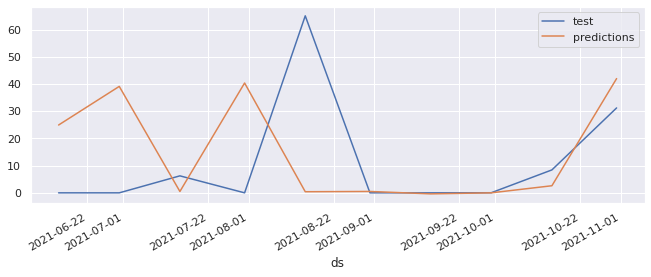

In [ ]:
fig, ax = plt.subplots(figsize=(11, 4))
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();